# Which models to use for epidemic prediction?
**<font size="3"> Comparison of Data-Driven and Model-Based Methods for Prediction of Influenza and COVID-19 Cases</font>**

**<font size="3">Co-authors: Erin Stafford, Eli Shlizerman</font>**
![title](headerpic.png)

In the time of COVID-19, the need for accurate predictions of both long-term and short-term evolution of epidemics has been made apparent. In order to determine which methods may be the most useful in making epidemic prediction, we propose to compare traditional model-based methods, such as Susceptible Infected Recovered model (SIR), with emerging data-driven based models including recurrent neural networks (RNN) for time series prediction. We propose to compare these different methods on influenza (flu) data which is more robust, and then examine applications to COVID-19. Our study shows the promise and generality of data-driven methods for both influenza and COVID-19, in particular, our study identifies the Seq2Seq neural network, previously demonstrated as an effective method in sequence prediction and clustering [1,2], as a promising approach for epidemic prediction.


## Highlights:
- Commonly used model-based methods such as SIR do not provide accurate long-term predictions on influenza data and require a constant update to be more accurate.
- Data-driven RNN based methods, such as vanilla-LSTM, do not provide accurate long-term predictions either.
- We identify Seq2Seq RNN as the most promising data-driven approach for both short term and long term predictions 
- We propose the following Seq2Seq applications to COVID-19 data: 
    - Since epidemics follow similar patterns, data-driven Seq2Seq trained on the flu could be used as a model for COVID-19. Such a model will require only a ‘few-shots’ retraining (several samples) to provide predictions.

## The Data: Flu
The Centers for Disease Control and Prevention (CDC) has surveillence systems in place for tracking the seasonal spread of influenza. One such network is the US Outpatient Influenza-like Illness Surveillance Network (ILINet). Each week, outpatient healthcare providers in ILINet report 
- The total number of patients seen for any reason
- The number of those patients with influenza-like illness (ILI) by age group

ILI is defined by
- Fever
- Cough and/or sore throat with out a known cause other than flu

ILINet provides data on a national, state, and regional level as well as percentages of visits due to ILI weighted by population and unweighted. **We will be looking at the national level data for weekly case counts.**

We will compare predictions of seasonal influenza from SIR models with Recurrent Neural Networks, Long Short Term Memory networks (LSTMs) and Seq2Seq networks, on this data.

### Step 1: Load the data

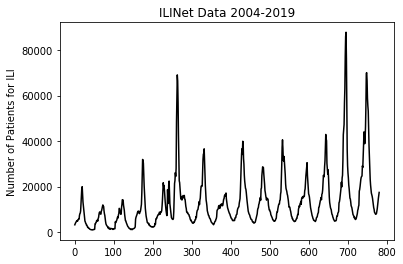

In [946]:
import pandas as pd
import matplotlib.pyplot as plt
ilinet_full = pd.DataFrame(pd.read_csv('ILINet.csv'))
ilinet_full_seasons =ilinet_full[0:782] #ignoring current season for now
data = ilinet_full_seasons['ILITOTAL'].values
weeks = ilinet_full_seasons['WEEK'].values[0:52]
plt.plot(data, color = 'black')
plt.title("ILINet Data 2004-2019")
plt.ylabel("Number of Patients for ILI")
plt.show()

We can see that influenza epidemics follow a similar pattern. Furthermore, we can see that 
- We are dealing with time-series data
- Most seasons are similar to the previous season.

To make the data easier to work with, we change the format to be seasonal.  (i.e looking at each yearly period with a center at week 14 - first week of April ).

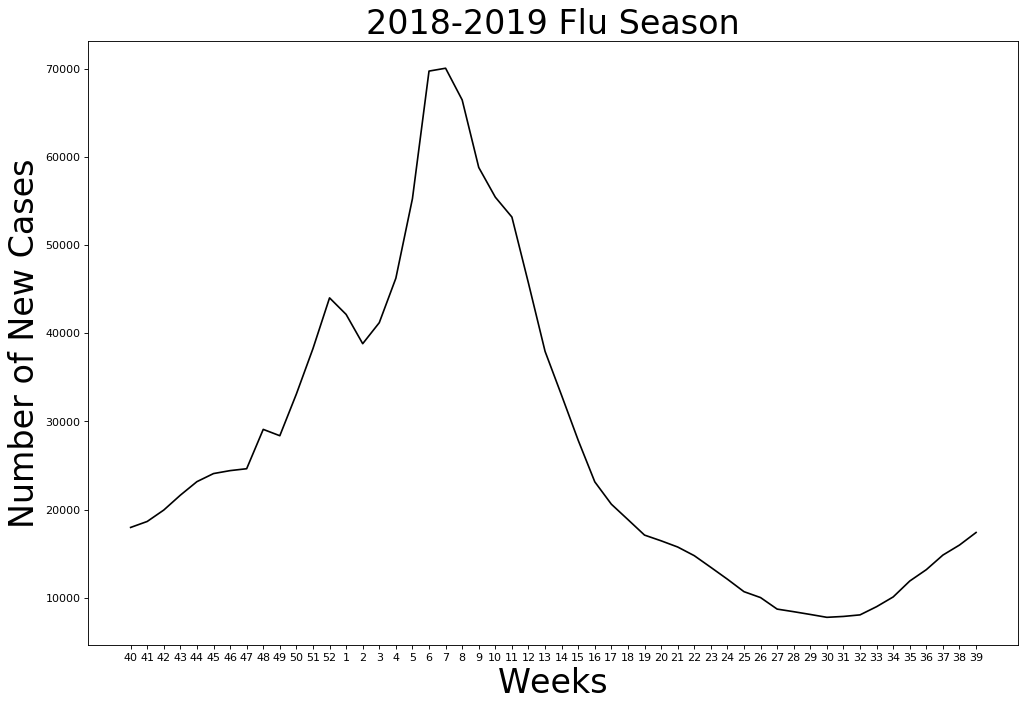

In [987]:
import numpy as np
end_weeks=ilinet_full_seasons.index[ilinet_full_seasons['WEEK'] == 39].tolist()
start_weeks=ilinet_full_seasons.index[ilinet_full_seasons['WEEK'] == 40].tolist()

seasons=[]
for i in range(len(start_weeks)):
    c=start_weeks[i]
    seasons.append(data[c:c+52])
    
fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(seasons[-1],color = 'black')
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks)
plt.xlabel("Weeks", fontsize=30)
plt.ylabel("Number of New Cases", fontsize=30)
plt.title("2018-2019 Flu Season", fontsize=30)
seasons=np.vstack(seasons)

## The SIR Model
The SIR model is a system of ordinary differential equations (ODEs) that have traditionaly been used to study the dynamics of epidemics.

In this model, the population is divided into three groups: Susceptible, Infected, and Recovered. A flow diagram of this model can be seen below.
![title](SIRmodel.png)
Susceptibles become infected with rate $\beta$, and infected recover with rate $\gamma$.

In order to use the SIR model to make predictions, we must optimize the parameters of the model to fit the data. The parameters we optimize include
- % of the population that is initially susceptible
- $\beta$: rate of infection
- $\gamma$: rate of recovery.

### Making predictions using an SIR model

First, we look at making predictions based on the previous season.

We optimize the model parameters **to fit the previous season** and then use these parameters to **run the model for the next season** and compare the results with real data of the next season.

In [921]:
from scipy.integrate import odeint
from scipy import optimize

# The SIR model differential equations.
def sir_model(y, t, params):
    S, I, R = y
    dSdt = -params[1] * S * I / (params[0]*N)
    dIdt = params[1] * S * I / (params[0]*N) - params[2] * I
    dRdt = params[2] * I
    return (dSdt, dIdt, dRdt)

def run_model(init, p):
    f = lambda y,t: sir_model(y, t, p)
    y0 = p[0]*N, init, 0
    sol = odeint(f, y0, t)
    S, I, R = sol.T
    return I,t

def error_fn(real,model):
    error = real-model
    # Since the peak week of a epidemic is an important feature, 
    # we want to make sure this value is accurate
    error[np.argmax(real)]=error[np.argmax(real)]*1000
    return error

def real_mod_comp(p,real):
    modelI,t = run_model(real[0], p)
    err=error_fn(real,modelI)
    # we want to make sure our parameters are biologically plausible
    if p[0]<0 or p[1]<0 or p[2]<0 or p[0]>1:
        err = err+10**6
    return err

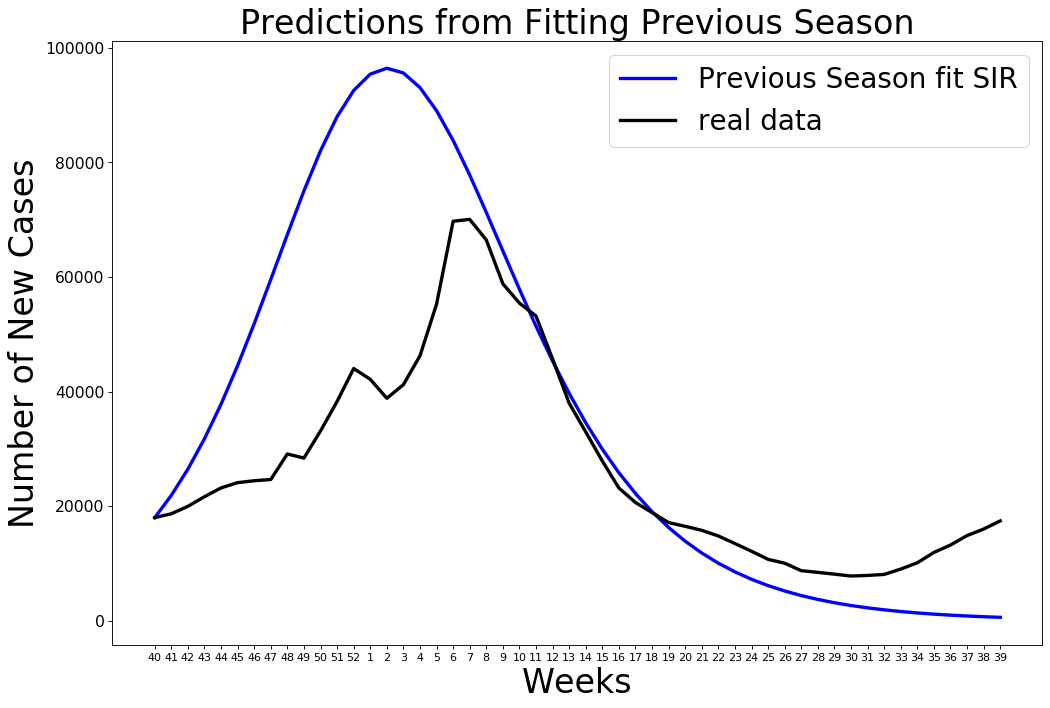

In [954]:
import warnings
warnings.filterwarnings("ignore")

N=300000000 #approximate US pop.
t = np.linspace(0, 52, 52)
p0=[.5,.7, 1./14]

#get parameters from fitting to last season
fn = lambda p: real_mod_comp(p,seasons[-2])
(c,kvg) = optimize.leastsq(fn, p0) 
p_prev=c

I,t=run_model(seasons[-1][0], p_prev)

fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks)

plt.plot(I, label="Previous Season fit SIR", linestyle='-', linewidth=3, color = 'blue')
plt.plot(seasons[-1],label="real data", linewidth=3,color = 'black')
plt.title("Predictions from Fitting Previous Season",fontsize=30)
plt.legend(prop={'size': 25})
plt.yticks(fontsize=14)
plt.xlabel("Weeks",fontsize=30)
plt.ylabel("Number of New Cases",fontsize=30)
plt.show()

Next, we see how the SIR model does making predictions **from only 10 data points.** 

We will do this in two ways:
- Fitting to the previous season and using these parameters as a starting point for optimization: **Smart SIR**

- Using a general starting point: **Naive SIR**

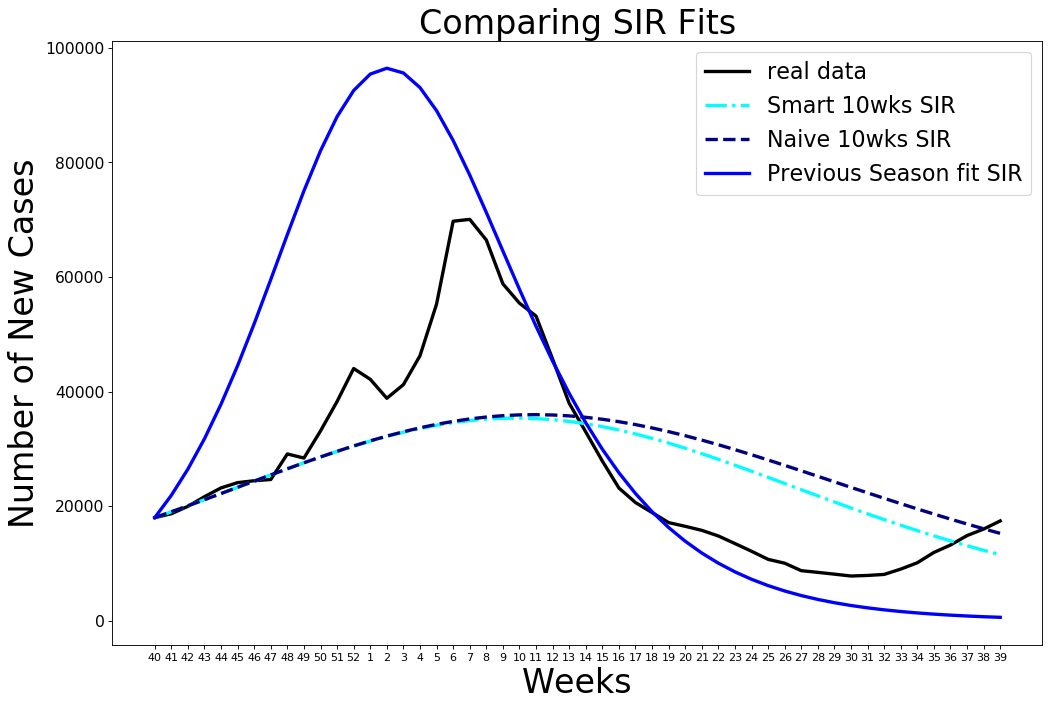

In [951]:
# since we now have only 10 weeks of data, we need to change the error functions
def error_fn_partial(real,model):
    error = real-model
    error[-1]= error[-1]*100 #weight last data point
    return error
def real_mod_comp_partial(p,real):
    c=0
    if p[0]<0 or p[1]<0 or p[2]<0:
        c = 10**10
    model,t = run_model(real[0], p)
    err=error_fn_partial(real,model)+c
    return err

N=300000000
p0=[.5,.7, 1./14]

fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks)
plt.plot(seasons[-1],label="real data", linewidth =3,color = 'black')

numwks=10
t = np.linspace(0, numwks,numwks)
fn = lambda p: real_mod_comp_partial(p,seasons[-1][0:numwks])
(c,kvg) = optimize.leastsq(fn, p_prev) 

t = np.linspace(0, 52, 52)
I2,t=run_model(seasons[-1][0], c)
plt.plot(I2, label="Smart 10wks SIR", linestyle='-.', linewidth =3, color='aqua')

t = np.linspace(0, numwks,numwks)
fn = lambda p: real_mod_comp_partial(p,seasons[-1][0:numwks])
(c,kvg) = optimize.leastsq(fn, p0) 

t = np.linspace(0, 52, 52)
I3,t=run_model(seasons[-1][0], c)
plt.plot(I3, label="Naive 10wks SIR", linestyle='--', linewidth =3, color = 'navy')
plt.legend()

plt.plot(I, label="Previous Season fit SIR", linestyle='-', linewidth =3,color = 'blue')
plt.title("Comparing SIR Fits",fontsize=30 )
plt.legend(prop={'size': 20})
plt.yticks(fontsize=14)
plt.xlabel("Weeks",fontsize=30)
plt.ylabel("Number of New Cases",fontsize=30)
plt.show()

In [955]:
print("Difference in Peak Value:")
print("Smart 10wks SIR:",abs(I2.max() - seasons[-1].max()))
print("Previous Season fit SIR:",abs(I.max() - seasons[-1].max()))
print("")
print("Difference in Peak Week:")
print("Smart 10wks SIR:",abs(np.argmax(I2) - np.argmax(seasons[-1])))
print("Previous Season fit SIR:",abs(np.argmax(I) - np.argmax(seasons[-1])))

Difference in Peak Value:
Smart 10wks SIR: 34705.343451666995
Previous Season fit SIR: 26391.165019990673

Difference in Peak Week:
Smart 10wks SIR: 3
Previous Season fit SIR: 5


The results tell us that using the SIR model fit to the previous season gives us the most overall accurate predictions from this model. However, the model that used only the first 10 weeks was better able to predict the peak week of the epidemic. Overall, we see that the SIR model even if updated on previous data does not capture important features of the epidemic evolution and indicates that **native data-driven approaches could improve the prediction**. 

## LSTM Network

A commonly used prediction strategy for time-series data (like the epidemic data of daily cases that we consider here) is recurrent neural networks (RNNs). Specific type of RNNs that could provide robust prediction are LSTMs (Long Short-Term Memory units). LSTMs are able to recognize temporal patterns in time series data that are then used in prediction [1]. 

Our implementation follows the following tutorial for time series prediction with LSTM in PyTorch:
 - https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

### Normalizing the data for LSTM

In [246]:
import torch
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
maxval = seasons[0:-1].max()
minval = seasons[0:-1].min()
scaleddata = scaler.fit_transform(seasons.reshape(-1, 1))
full_data = torch.FloatTensor(scaleddata).view(-1)
train_data = full_data[:-52] #removing last season from training data

### Creating input-output sequences to train the model
Next, we create tuples that will be used to train the model. These tuples will contain 52 weeks of data as the input and the following week as the output.

In [247]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_window = 52
train_inout_seq = create_inout_sequences(train_data, train_window)

An example of the input/output sequence is given below. There are 52 data points in each input sequence with one label, which is the next data point.

In [248]:
print(train_inout_seq[0])

(tensor([-0.9482, -0.9377, -0.9287, -0.9207, -0.9165, -0.9069, -0.9065, -0.9128,
        -0.8968, -0.8963, -0.8888, -0.8903, -0.8537, -0.8362, -0.8297, -0.8065,
        -0.7353, -0.6486, -0.5755, -0.5625, -0.6385, -0.7166, -0.7542, -0.8025,
        -0.8394, -0.8756, -0.9104, -0.9189, -0.9332, -0.9373, -0.9524, -0.9519,
        -0.9630, -0.9739, -0.9729, -0.9811, -0.9841, -0.9838, -0.9899, -0.9936,
        -0.9948, -0.9966, -0.9984, -0.9986, -0.9977, -0.9999, -1.0000, -0.9974,
        -0.9968, -0.9976, -0.9932, -0.9935]), tensor([-0.9387]))


Now we construct the model.

In [197]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
model = LSTM()
loss_function = nn.L1Loss()#MSELoss()#L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

We train the model on the input/output sequences we created earlier, i.e., we slide a window of 52 data-points (one season) over the whole training data by a single step at a time and predict the next point. We then compute the L1 loss between the predicted value and the ground truth.

In [198]:
epochs = 40
losses=[]
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        losses.append(single_loss)
        single_loss.backward()
        optimizer.step()
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.01718307
epoch:  26 loss: 0.01689130
epoch:  39 loss: 0.0139082670


Epoch with minimum loss:  25


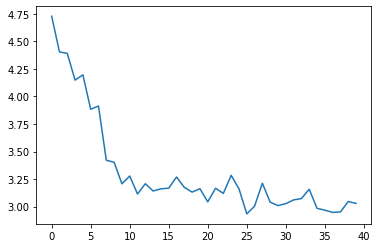

In [199]:
losses=[float(i) for i in losses]
lossperepoch  =[]
sep=int(len(losses)/epochs)
c=0
for i in range(0,len(losses),sep):
    lossperepoch.append(sum(losses[c*sep:c*sep+sep]))
    c=c+1
plt.plot(range(0,epochs),np.log(lossperepoch))
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Training Loss'])
plt.show()
print("Epoch with minimum loss: ",np.argmin(lossperepoch))

It looks like the model converges (although notice that the loss is pretty high). Lets see what the predictions for the next season look like.

In [974]:
fut_pred = 52

test_inputs = train_data.tolist()
predictions=[]
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        pred=model(seq).item()
        test_inputs.append(pred)
        predictions.append(pred)
actual_predictions = np.array(predictions)

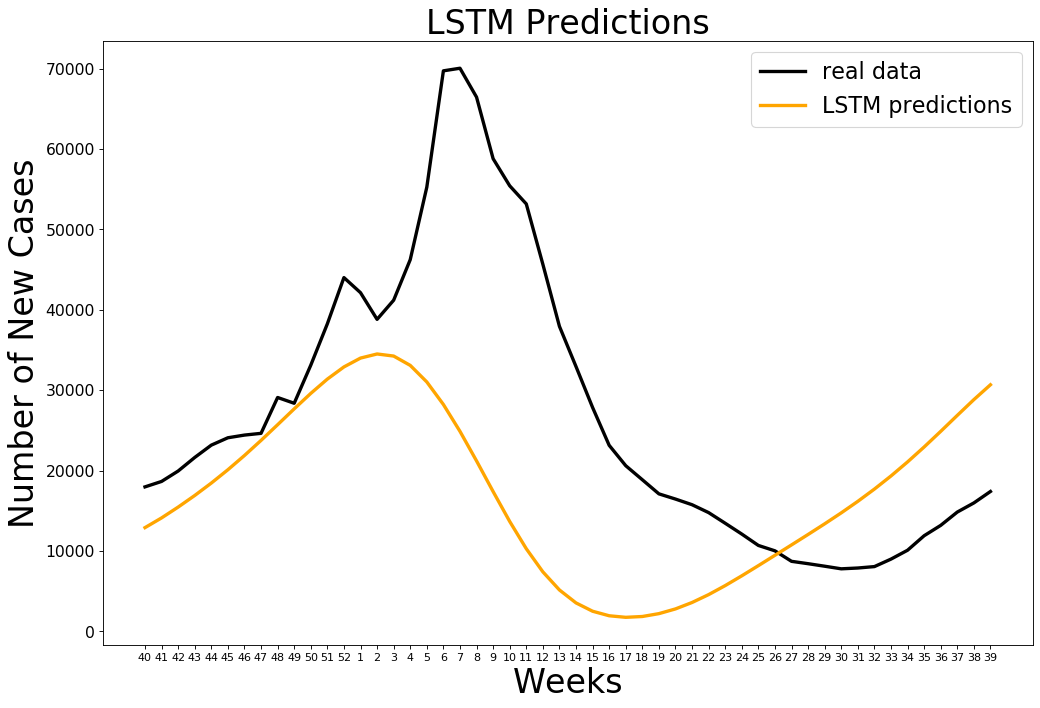

In [978]:
unscaled = scaler.inverse_transform(actual_predictions.reshape(-1, 1))

fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks)
plt.plot(seasons[-1], label='real data', linewidth=3, color='black')
plt.plot(unscaled, label='LSTM predictions',linewidth = 3, color='orange')
plt.legend(prop={'size': 20})
plt.yticks(fontsize=14)
plt.title("LSTM Predictions",fontsize=30)
plt.xlabel("Weeks",fontsize=30)
plt.ylabel("Number of New Cases",fontsize=30)
plt.show()

There predictions aren't very good, but let's see how they compare to the SIR model.

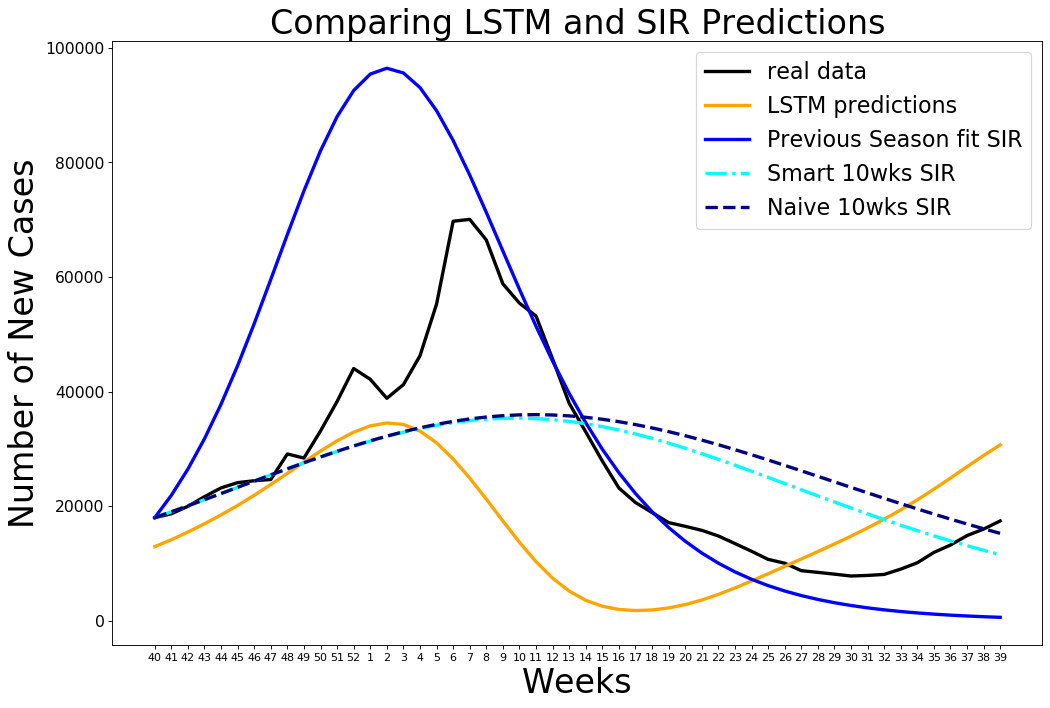

In [979]:
fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks)
plt.plot(seasons[-1], label='real data',linewidth =3, color='black')
plt.plot(unscaled, label='LSTM predictions',linewidth =3,color='orange')
plt.plot(I, label="Previous Season fit SIR", linestyle='-',linewidth =3, color='blue')
plt.plot(I2, label="Smart 10wks SIR", linestyle='-.', linewidth =3, color='aqua')
plt.plot(I3, label="Naive 10wks SIR", linestyle='--',linewidth =3, color='navy')
plt.legend(prop={'size': 20})
plt.yticks(fontsize=14)
plt.title("Comparing LSTM and SIR Predictions",fontsize=30)
plt.xlabel("Weeks",fontsize=30)
plt.ylabel("Number of New Cases",fontsize=30)
plt.show()

In [980]:
print("Difference in Peak Value:")
print("LSTM Predictions:",abs(unscaled.max() - seasons[-1].max()))
print("Best SIR Prediction:",abs(I.max() - seasons[-1].max()))
print("")
print("Difference in Peak Week:")
print("LSTM Predictions:",abs(np.argmax(unscaled) - np.argmax(seasons[-1])))
print("Best SIR Prediction:",abs(np.argmax(I) - np.argmax(seasons[-1])))

Difference in Peak Value:
LSTM Predictions: 35547.32227896898
Best SIR Prediction: 26391.165019990673

Difference in Peak Week:
LSTM Predictions: 5
Best SIR Prediction: 5


**This is doing worse than the SIR model!**

 Furthermore, predictions from LSTM were not very reliable and tended to produce different results after training. However, in some cases the results were more accurate than SIR, and notably in many of the trials LSTM tends to capture the uptick in new cases towards the end of the season.


## Seq2Seq Model

Seq2Seq models use RNN encoder and decoder layers that convert one sequence to another. Although this is typically used for language processing, it is also suited to time series forecasting, see [4].

- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

The implementation of this model is adapted from Time Series prediction Seq2Seq [5] and [1,2].

- https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb


We set up Se2Seq to perform similar prediction as ‘Previous Season fit SIR’ and ‘LSTM’. We set the input into the encoder to be the previous season ( ‘Encoding Series’ of 52 weeks - black) and train the output of the decoder to predict 52 weeks of the current season (‘Target Series’ of 52 weeks - green). We train the model on all previous seasons and leave the last season for testing. The prediction of Seq2Seq is marked in red color.

In [1052]:
#normalize data
normalized_seasons=(seasons-seasons.min())/(seasons.max()-seasons.min())

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")


latent_dim = 50 # LSTM hidden units
dropout = .20 

encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, 1)) 

decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)

decoder_dense = Dense(1) 
decoder_outputs = decoder_dense(decoder_outputs)

model_flu = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [1053]:
def transform_series_encode(series_array):
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = series_array - np.zeros([len(encode_series_mean),1])#encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [1054]:
encoder_input_data = normalized_seasons[0:-2]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_seasons[-2]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [1055]:
batch_size = 2**11
epochs = 100

encoder_input_data = normalized_seasons[0:-2]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_seasons[-2] 
                                            
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model_flu.compile(Adam(), loss='mean_absolute_error')#'mean_squared_error')
history = model_flu.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2,verbose=0);

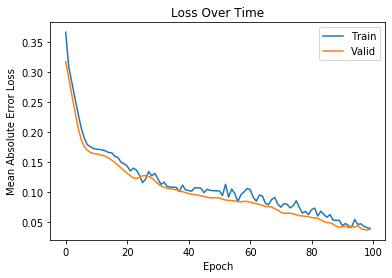

In [1056]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])
plt.show()

In [1057]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, 1))
    
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        states_value = [h, c]

    return decoded_seq

In [1058]:
encoder_input_data = normalized_seasons[0:-1]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_seasons[-1]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

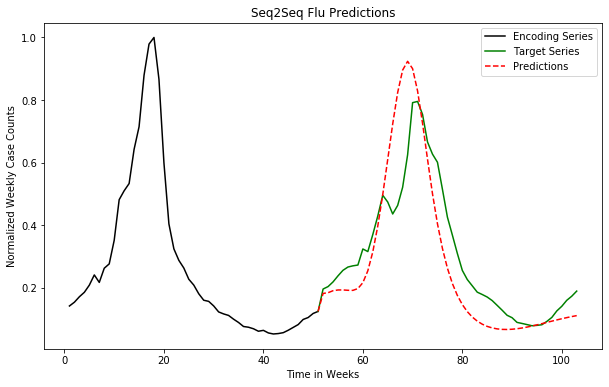

In [1060]:
pred_steps=52
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=51):
    encode_series = encoder_input_data
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:].reshape(-1,1) 
    target_series =np.concatenate([encode_series[-1:],target_series])
    encode_series_tail = encode_series[-enc_tail_len:]
    x_encode = encode_series_tail.shape[0]
    
    #to show continuity
    preds = np.zeros((pred_steps+1,1))
    preds[0]=encode_series_tail[-1]
    preds[1:]=pred_series
    
    plt.figure(figsize=(10,6))  
    plt.plot(range(1,x_encode+1),encode_series_tail, color='black')
    plt.plot(range(x_encode,x_encode+pred_steps+1),target_series,color='green')
    plt.plot(range(x_encode,x_encode+pred_steps+1),preds,color='red',linestyle='--')
    
    plt.title('Seq2Seq Flu Predictions')
    plt.xlabel('Time in Weeks')
    plt.ylabel('Normalized Weekly Case Counts')
    plt.legend(['Encoding Series','Target Series','Predictions'])
    return pred_series
preds= predict_and_plot(encoder_input_data, decoder_target_data, 13)

We can already see that seq2seq is doing much better than our other prediction strategies, but let's visualize this.

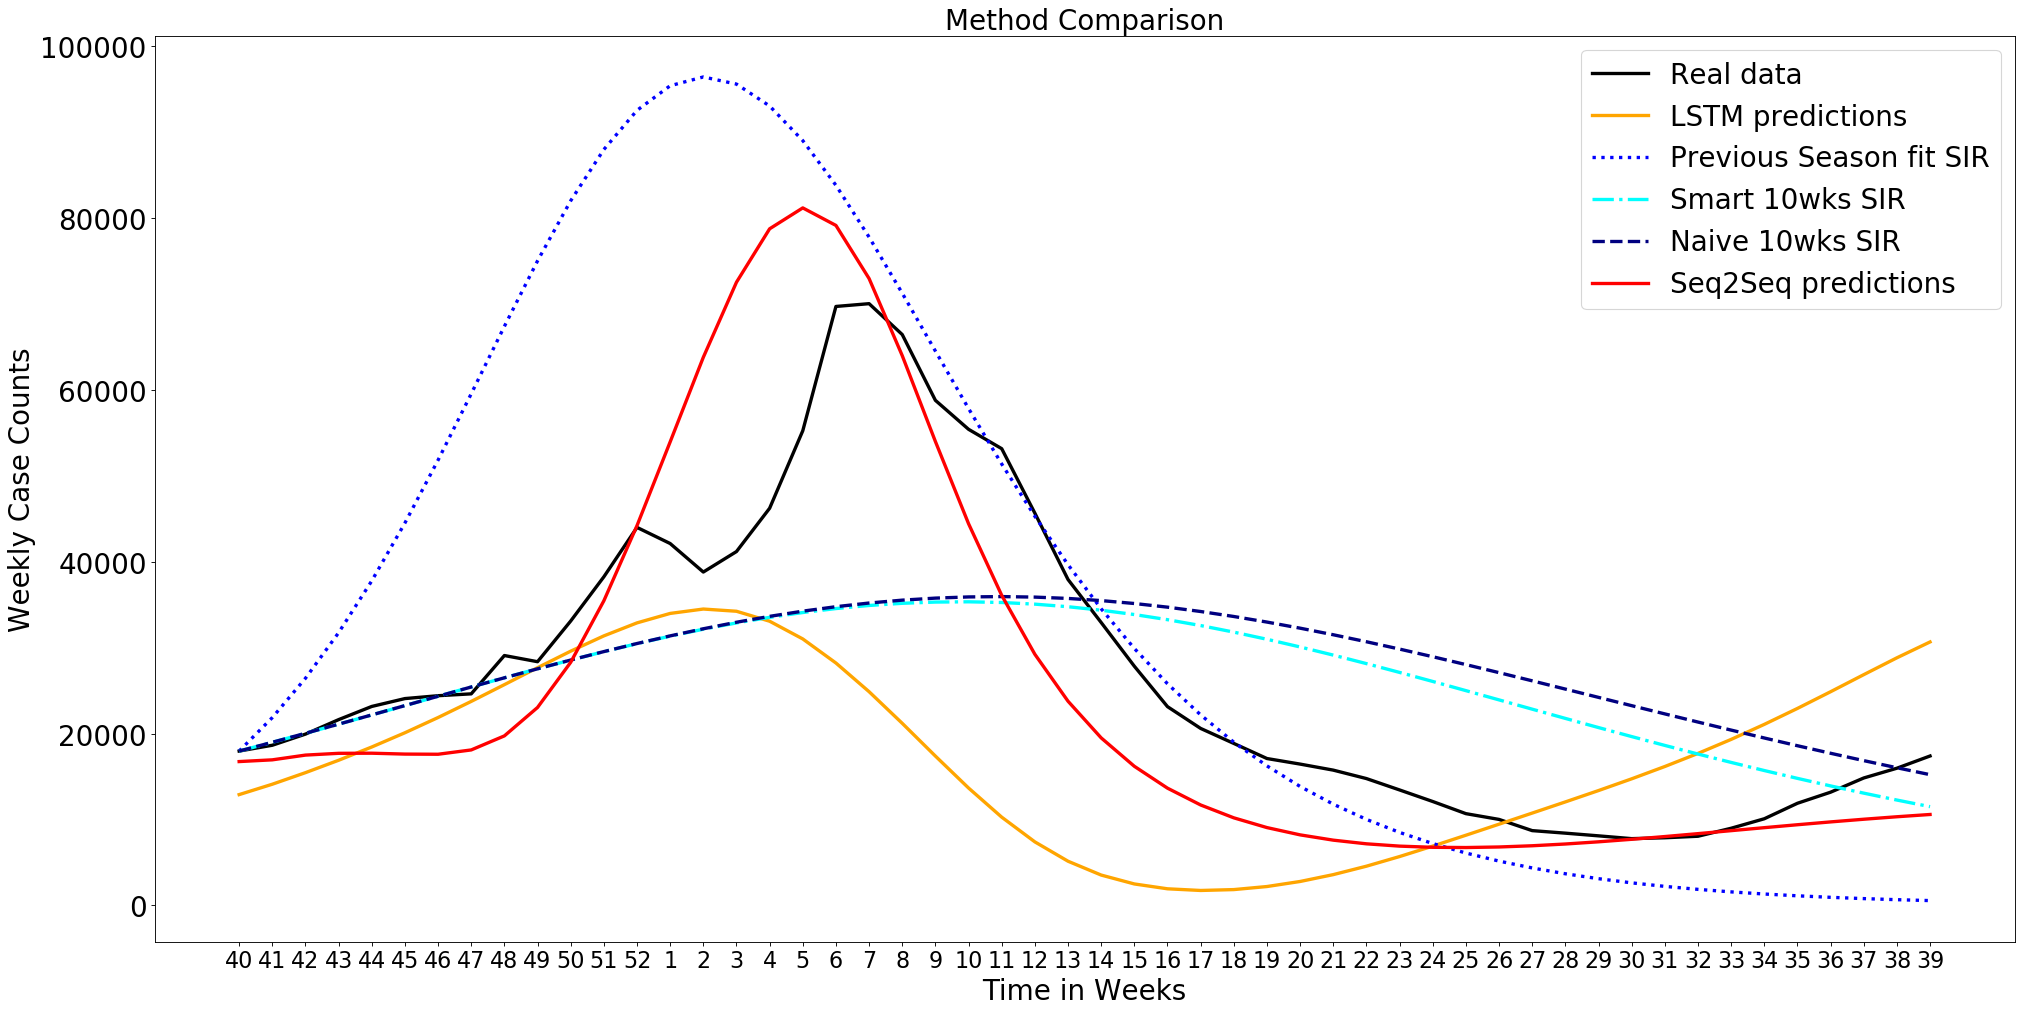

In [1061]:
unscaled2 =preds*(seasons.max()-seasons.min())+seasons.min()
fig=plt.figure(figsize=(30, 15), dpi= 80, facecolor='w', edgecolor='k')
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks,fontsize=20)
plt.plot(seasons[-1], label='Real data', linewidth =3, color='black')
plt.plot(unscaled, label='LSTM predictions', linewidth =3,color='orange')
plt.plot(I, label="Previous Season fit SIR", linestyle=':', linewidth =3, color='blue')
plt.plot(I2, label="Smart 10wks SIR", linestyle='-.', linewidth =3, color='aqua')
plt.plot(I3, label="Naive 10wks SIR", linestyle='--', linewidth =3, color='navy')
plt.plot(unscaled2, label='Seq2Seq predictions', linestyle='-', linewidth =3, color='red')
plt.xlabel('Time in Weeks',fontsize=25)
plt.ylabel('Weekly Case Counts',fontsize=25)
plt.title("Method Comparison",fontsize=25)
plt.legend(prop={'size': 25})
plt.yticks(fontsize=25)
plt.show()

In [ ]:
print("Difference in Peak Value:")
print("LSTM Predictions:",abs(unscaled.max() - seasons[-1].max()))
print("Best SIR Prediction:",abs(I.max() - seasons[-1].max()))
print("Seq2Seq Predictions:",abs(unscaled2.max() - seasons[-1].max()))
print("")
print("Difference in Peak Week:")
print("LSTM Predictions:",abs(np.argmax(unscaled) - np.argmax(seasons[-1])))
print("Best SIR Prediction:",abs(np.argmax(I) - np.argmax(seasons[-1])))
print("Seq2Seq Predictions:",abs(np.argmax(unscaled2) - np.argmax(seasons[-1])))

As the comparison plot above shows, Seq2Seq predictions do **significantly better** than both SIR and LSTM on predicting the peak value of the epidemic, the peak week and the overall shape of the curve appears to be close to the Real data curve, almost as a smoothed version of the Real data curve. 

# Application of Seq2Seq to predict COVID-19 epidemic

Since the results from using Seq2Seq on the flu data are promising, we are motivated to see how well we can predict COVID-19 data with our best data-driven approach - the Seq2Seq model. The data used for this application is from the COVID-19 Global Forcasting challenge on Kaggle [6]. The data includes confirmed cases and fatalities on the level of country, state, county, as well as the population of each region.

### Loading the data

In [1034]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.DataFrame(pd.read_csv('train.csv'))
data

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0.0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0.0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0.0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0.0
...,...,...,...,...,...,...,...,...,...
824189,969594,NaN,NaN,Zimbabwe,14240168,0.607106,2020-05-18,Fatalities,0.0
824190,969595,NaN,NaN,Zimbabwe,14240168,0.060711,2020-05-19,ConfirmedCases,0.0
824191,969596,NaN,NaN,Zimbabwe,14240168,0.607106,2020-05-19,Fatalities,0.0
824192,969597,NaN,NaN,Zimbabwe,14240168,0.060711,2020-05-20,ConfirmedCases,2.0


We will focus on the US data for our experiments.

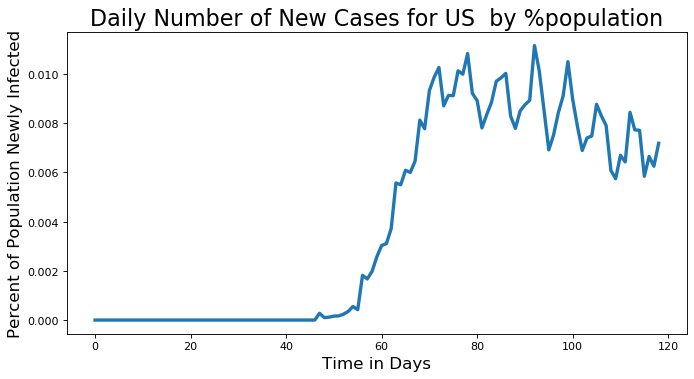

In [1047]:
US_data = data.loc[data['Country_Region'] == 'US']
US_data_cases = US_data.loc[US_data['Target'] == 'ConfirmedCases']
US_data_cases = US_data_cases.loc[US_data_cases['Population'] == 324141489]
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(US_data_cases['TargetValue'].values/324141489*100, linewidth = 3)
plt.title("Daily Number of New Cases for US  by %population",fontsize=20)
plt.xlabel("Time in Days",fontsize=15)
plt.ylabel("Percent of Population Newly Infected",fontsize=15)
plt.show()

In [552]:
states_train =['Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee',  'Utah', 'Vermont','Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming']
states_test=['Alabama','New York','Texas']
df_train = pd.DataFrame(columns =['Date']+states_train)#columns = states
df_train["Date"] = US_data_cases["Date"].values

df_test = pd.DataFrame(columns =['Date']+states_test)#columns = states
df_test["Date"] = US_data_cases["Date"].values

In [553]:
train_data_as_array=[]
for state in states_train:
    state_data=US_data.loc[US_data['Province_State'] == state]
    state_pop = state_data['Population'].max()
    state_data_cases = state_data.loc[state_data['Target'] == 'ConfirmedCases']
    state_data_cases = state_data_cases.loc[state_data_cases['Population'] == state_pop]
    df_train[state]=state_data_cases['TargetValue'].values
    max_cases = df_train[state].max()
    min_cases = df_train[state].min()
    df_train[state]=(df_train[state]-min_cases)/(max_cases-min_cases)
    train_data_as_array.append(df_train[state].values)
train_data_as_array=np.vstack(train_data_as_array)

In [554]:
test_data_as_array=[]
for state in states_test:
    state_data=US_data.loc[US_data['Province_State'] == state]
    state_pop = state_data['Population'].max()
    state_data_cases = state_data.loc[state_data['Target'] == 'ConfirmedCases']
    state_data_cases = state_data_cases.loc[state_data_cases['Population'] == state_pop]
    df_test[state]=state_data_cases['TargetValue'].values
    max_cases = df_test[state].max()
    min_cases = df_test[state].min()
    df_test[state]=(df_test[state]-min_cases)/(max_cases-min_cases)
    test_data_as_array.append(df_test[state].values)
test_data_as_array=np.vstack(test_data_as_array)

We will address three main questions with our experiments:
1. Using Seq2Seq to predict the last 45 days of epidemic data (number of cases) for each state. This will determine the accuracy of such data-driven prediction for the COVID-19 data.

2. Finally, we explore whether the Seq2Seq model trained on the flu data as a data-driven model can be used as a prediction of COVID-19. We would like to explore with this setup whether training Seq2Seq on an epidemic that has similarities with COVID-19 would be better equipped to predict COVID-19 dynamics and effectively serves as a hybrid data and model based approach for accurate predictions.   


### 1. Using Seq2Seq to predict the last 45 days of epidemic data by state

For this application, we train a Seq2Seq neural network to predict the last 45 days of an epidemic using the beginning of the epidemic as input. We show 3 example states (use the code to generate the same for other 47 states).  The daily prediction is shown on the left (compare prediction-red with target-green ). We are able to capture an overall trend but not the spikes in the data that correspond to variations in measurements. We thereby look at moving averages, updated each day and show the precision on the right (compare prediction-red with magenta-7day moving average target). As can be seen we are getting impressive accuracy for a number of examined states. 


In [1025]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")


latent_dim = 50 # LSTM hidden units
dropout = .20 

encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, 1)) 

decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)

decoder_dense = Dense(1) 
decoder_outputs = decoder_dense(decoder_outputs)

model_covid = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [1026]:
def create_encoder_target_pairs(data):
    e_data = []
    t_data = []
    if len(data)!=119:
        for i in range(len(data)):
            e_data.append(data[i][0:-45])
            t_data.append(data[i][-45:])
    else:
        e_data.append(data[0:-45])
        t_data.append(data[-45:])
    return [np.array(e_data),np.array(t_data)]

In [1027]:
[e_data,t_data]=create_encoder_target_pairs(train_data_as_array)

In [1028]:
batch_size = 2**11
epochs = 100

encoder_input_data = e_data
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = t_data
                                            
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model_covid.compile(Adam(), loss='mean_absolute_error')
history = model_covid.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2,verbose=0);

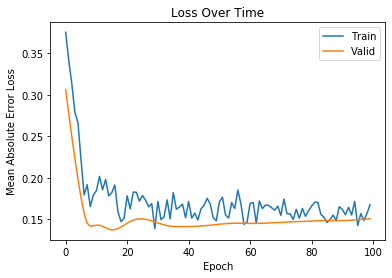

In [1029]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])
plt.show()

In [1030]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq,pred_steps):
    
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, 1))
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        states_value = [h, c]

    return decoded_seq

In [1031]:
def get_cumulative_data(data):
    c_data = np.zeros((len(data),1))
    c_data[0]=data[0]
    for i in range(1,len(data)):
        c_data[i]=c_data[i-1]+data[i]
    return c_data

def get_cumulative_data_preds(edata, tdata):
    c_edata = get_cumulative_data(edata)
    c_data = np.zeros((len(tdata),1))
    c_data[0] = tdata[0]+c_edata[-1]
    for i in range(1,len(tdata)):
        c_data[i]=c_data[i-1]+tdata[i]
    return c_data
def get_rolling_average(edata, tdata, numsteps):
    c = 0
    pred_steps=numsteps
    rolling_preds=[edata[-1][-1]]
    for i in range(len(tdata[0])):
        encoder_input_data = np.array([np.append(edata[0],tdata[0][0:c])])
        encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
    
        decoder_target_data = [t_data[0][c:c+pred_steps]]
        decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
    
        rolling_preds= np.append(rolling_preds,np.mean(decode_sequence(encoder_input_data,pred_steps)))
        c=c+1
    target = np.append([edata[-1][-1]],tdata[0])
    rolling_data = pd.Series(target).rolling(window = numsteps)
    rolling_mean = rolling_data.mean()
    return rolling_preds, target, rolling_mean

In [1032]:
def predict_and_plot(e_data, t_data, enc_tail_len=len(e_data[0])):
    pred_steps=len(t_data[0])
    encoder_input_data = e_data
    encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

    decoder_target_data = t_data
    decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
    
    encode_series = encoder_input_data
    pred_series = decode_sequence(encode_series,pred_steps)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    
    target_series = decoder_target_data.reshape(-1,1) 
    target_series =np.concatenate([encode_series[-1:],target_series])
    
    encode_series_tail = encode_series[-enc_tail_len:]
    x_encode = encode_series_tail.shape[0]
    
    #to show continuity
    preds = np.zeros((pred_steps+1,1))
    preds[0]=encode_series_tail[-1]
    preds[1:]=pred_series
    
    
    plt.figure(figsize=(20,6))  
    plt.subplot(1, 2, 1)  
    plt.plot(range(x_encode,x_encode+pred_steps+1),target_series,color='green')
    plt.plot(range(x_encode,x_encode+pred_steps+1),preds,color='red',linestyle='--')
    plt.plot(range(1,x_encode+1),encode_series_tail, color='black')
    plt.legend(['Target Series','Predictions'])
    
    [preds_rolling, target, rolling_mean]=get_rolling_average(e_data, t_data, 7)
    plt.subplot(1, 2, 2) 
    plt.plot(range(x_encode,x_encode+pred_steps+1),target,color='green', label = 'Target Series')
    plt.plot(range(x_encode,x_encode+pred_steps+1),preds_rolling,color='red',linestyle='--',label = '7-Day Moving Average Predictions' )
    plt.plot(range(x_encode,x_encode+pred_steps+1),rolling_mean,color='m', label='7-Day Moving Average Data')
    plt.legend()
    plt.plot(range(1,x_encode+1),encode_series_tail, color='black')
    return pred_series


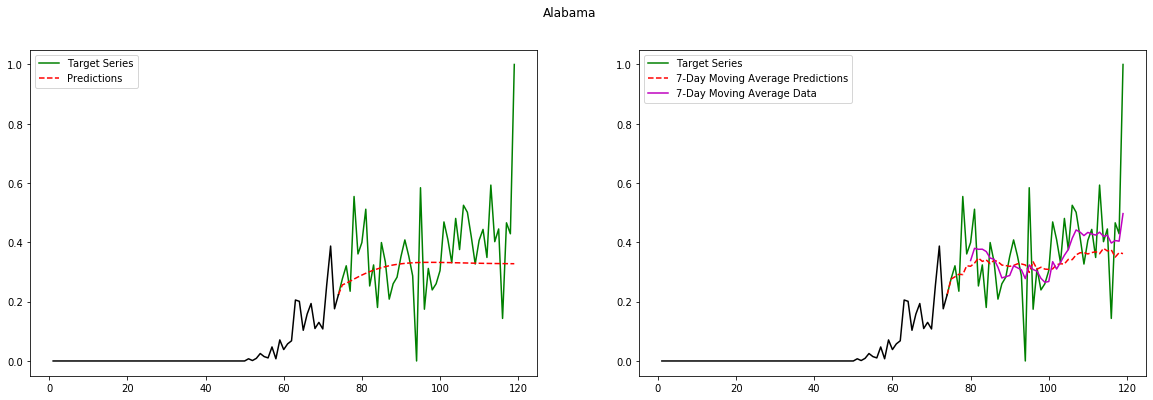

In [1003]:
[e_data,t_data]=create_encoder_target_pairs(test_data_as_array[0])
preds= predict_and_plot(e_data,t_data)
plt.suptitle("Alabama")
plt.show()

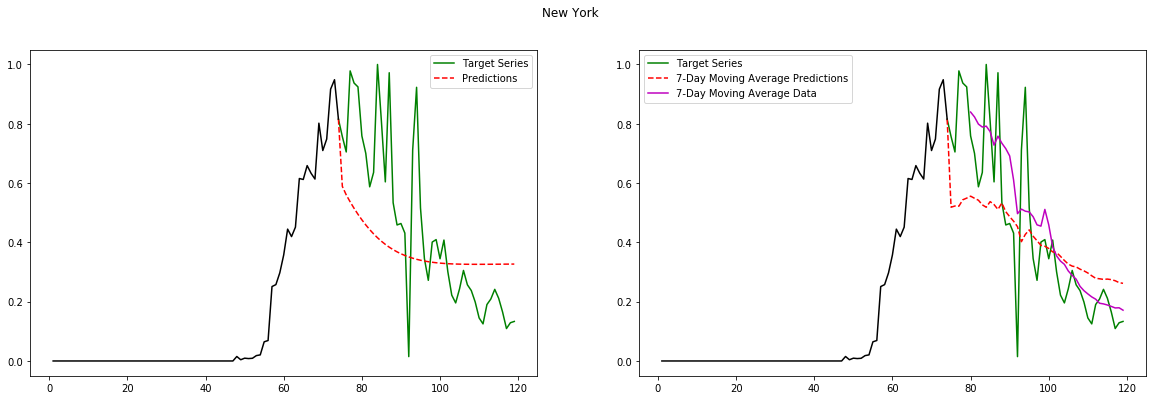

In [1004]:
[e_data,t_data]=create_encoder_target_pairs(test_data_as_array[1])

preds= predict_and_plot(e_data,t_data)
plt.suptitle("New York")
plt.show()

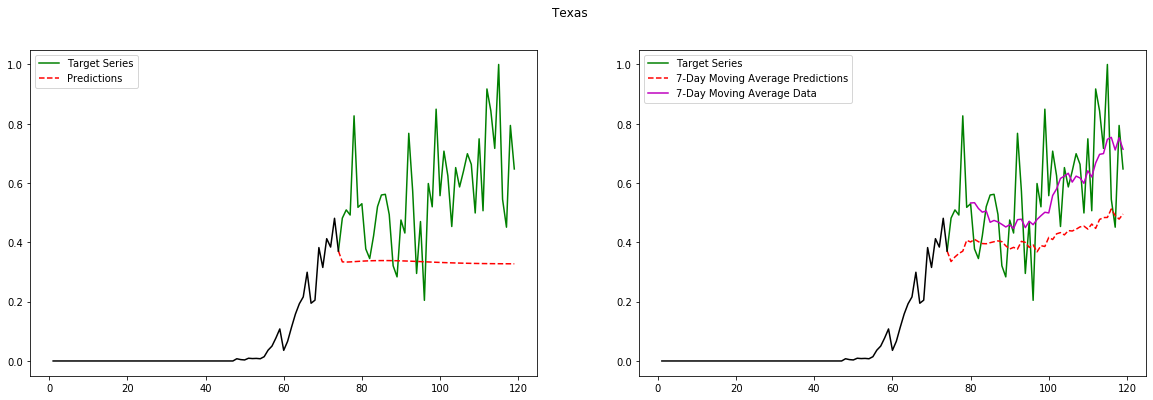

In [1005]:
[e_data,t_data]=create_encoder_target_pairs(test_data_as_array[2])
preds= predict_and_plot(e_data,t_data)
plt.suptitle("Texas")
plt.show()

We can see that we were not able to capture all of the spikes in the daily number of new cases, but we were able to capture an overall trend. Furthermore, some predictions were more accurate that others. 

However, these are long-term predictions, and we are more interested in short-term predictions. Therefore, we want to look at moving averages, which are updated each day.

### 2. Does flu data give us a better model to use for COVID-19 data?
For this application, we **first train** Seq2Seq on the flu data and then *re-train* it to predict the COVID-19 data. By following such a protocol we hope to obtain a model-based approach for COVID-19 which with a small amount of re-training provides accurate predictions.

In [1016]:
[e_data,t_data]=create_encoder_target_pairs(test_data_as_array) # using three states since we want few-shots

In [1017]:
batch_size = 2**11
epochs = 100

encoder_input_data = e_data
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = t_data                   
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

In [1018]:
history = model_flu.fit([encoder_input_data, decoder_input_data], decoder_target_data, epochs = 100,verbose=0);

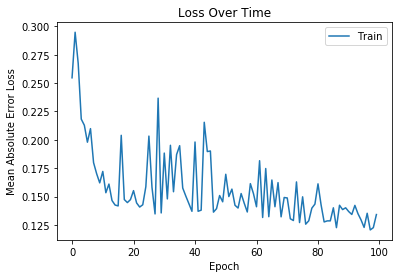

In [1019]:
plt.plot(history.history['loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train'])
plt.show()

In [1020]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq,pred_steps):
    
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, 1))
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        states_value = [h, c]

    return decoded_seq

Now, we look at the seven-day moving average:

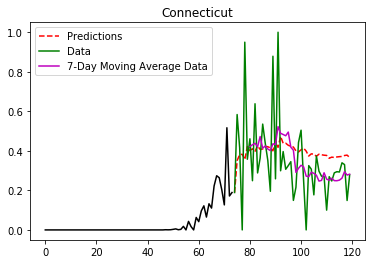

In [1021]:
[e_data,t_data]=create_encoder_target_pairs(train_data_as_array[5])
[preds_rolling, target, rolling_mean]=get_rolling_average(e_data, t_data, 7)
plt.plot(e_data[0], color='black')
plt.plot(range(len(e_data[0]),len(e_data[0])+len(preds_rolling)),preds_rolling,color='red',linestyle='--', label='Predictions')
plt.plot(range(len(e_data[0]),len(e_data[0])+len(target)),target,color='green', label='Data')
plt.plot(range(len(e_data[0]),len(e_data[0])+len(target)),rolling_mean,color='m', label='7-Day Moving Average Data')

plt.title(states_train[5])
plt.legend()
plt.show()

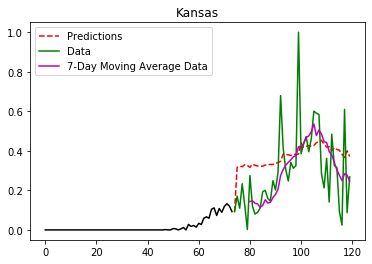

In [1022]:
[e_data,t_data]=create_encoder_target_pairs(train_data_as_array[15])
[preds, target, rolling_mean]=get_rolling_average(e_data, t_data, 7)
plt.plot(e_data[0], color='black')
plt.plot(range(len(e_data[0]),len(e_data[0])+len(preds)),preds,color='red',linestyle='--', label='Predictions')
plt.plot(range(len(e_data[0]),len(e_data[0])+len(target)),target,color='green', label='Data')
plt.plot(range(len(e_data[0]),len(e_data[0])+len(target)),rolling_mean,color='m', label='7-Day Moving Average Data')

plt.title(states_train[15])
plt.legend()
plt.show()

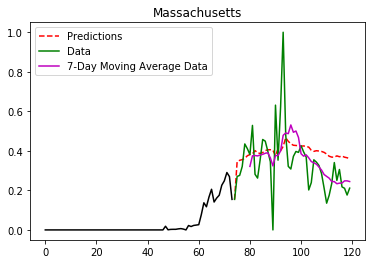

In [1023]:
[e_data,t_data]=create_encoder_target_pairs(train_data_as_array[20])
[preds, target, rolling_mean]=get_rolling_average(e_data, t_data, 7)
plt.plot(e_data[0], color='black')
plt.plot(range(len(e_data[0]),len(e_data[0])+len(preds)),preds,color='red',linestyle='--', label='Predictions')
plt.plot(range(len(e_data[0]),len(e_data[0])+len(target)),target,color='green', label='Data')
plt.plot(range(len(e_data[0]),len(e_data[0])+len(target)),rolling_mean,color='m', label='7-Day Moving Average Data')
plt.title(states_train[20])
plt.legend()
plt.show()

## Conclusions
- Seq2Seq is a reliable tool for epidemic prediction
    - Success with both COVID and flu
    - outperforms SIR and LSTMs
- Seq2Seq models trained on flu data provided insight into COVID data
- There may be more applications of Seq2Seq
    - insight into effective mitigation strategies
    
In this analysis of epidemic prediction methods, we have found that Seq2Seq neural networks are a reliable tool for epidemic prediction. Seq2Seq outperforms SIR and LSTMs for the prediction of flu data and shows promising results for COVID-19 prediction. Furthermore, the Seq2Seq model trained on flu data was able to make accurate predictions of COVID-19 data with little retraining. 

## References
1. Su, K., & Shlizerman, E. (2019). Dimension Reduction Approach for Interpretability of Sequence to Sequence Recurrent Neural Networks. arXiv preprint arXiv:1905.12176.
2. Su, K., Liu, X., & Shlizerman, E. (2020). Predict & cluster: Unsupervised skeleton based action recognition. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 9631-9640).
3. https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
4. https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
5. https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb
6. https://www.kaggle.com/c/covid19-global-forecasting-week-5/data?select=test.csv
7. https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
8. https://wallethub.com/edu/states-with-the-fewest-coronavirus-restrictions/73818/